In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import copy

# Airline scheduling problem data
flights = [
    {"id": 0, "origin": "A", "destination": "B", "departure": 8, "arrival": 10, "min_type": 1},
    {"id": 1, "origin": "B", "destination": "A", "departure": 11, "arrival": 13, "min_type": 1},
    {"id": 2, "origin": "A", "destination": "C", "departure": 9, "arrival": 11, "min_type": 2},
    {"id": 3, "origin": "C", "destination": "A", "departure": 12, "arrival": 14, "min_type": 2},
    {"id": 4, "origin": "A", "destination": "B", "departure": 10.5, "arrival": 12, "min_type": 1},
    {"id": 5, "origin": "B", "destination": "C", "departure": 12, "arrival": 14, "min_type": 3},
    {"id": 6, "origin": "C", "destination": "B", "departure": 15, "arrival": 17, "min_type": 3},
    {"id": 7, "origin": "A", "destination": "B", "departure": 7, "arrival": 9, "min_type": 1},
    {"id": 8, "origin": "B", "destination": "C", "departure": 10, "arrival": 12, "min_type": 2},
    {"id": 9, "origin": "C", "destination": "A", "departure": 13, "arrival": 15, "min_type": 1},
]

aircrafts = [
    {"id": 0, "type": 1, "base": "A"},
    {"id": 1, "type": 2, "base": "B"},
    {"id": 2, "type": 3, "base": "C"},
    {"id": 3, "type": 1, "base": "A"},
    {"id": 4, "type": 2, "base": "B"},
    {"id": 5, "type": 3, "base": "C"},
]

delay_prob = defaultdict(lambda: defaultdict(float), {
    ("A", "B"): {1: 0.10, 2: 0.05, 3: 0.15},
    ("B", "A"): {1: 0.12, 2: 0.06, 3: 0.18},
    ("A", "C"): {1: 0.25, 2: 0.10, 3: 0.20},
    ("C", "A"): {1: 0.20, 2: 0.08, 3: 0.22},
    ("B", "C"): {1: 0.15, 2: 0.05, 3: 0.12},
    ("C", "B"): {1: 0.18, 2: 0.07, 3: 0.14},
})

In [10]:

import random
random.seed(21)
NUM_FLIGHTS = 30
NUM_PLANES = 20
AIRPORTS = ["A", "B", "C"]
MAX_TYPE = 3

# Crear vuelos
flights = []
for i in range(NUM_FLIGHTS):
    origen = random.choice(AIRPORTS)
    destino = random.choice([a for a in AIRPORTS if a != origen])
    salida = random.uniform(6, 18)
    duracion = random.uniform(1, 3)
    llegada = salida + duracion
    tipo_min = random.randint(1, MAX_TYPE)
    flights.append({
        "id": i, "origin": origen, "destination": destino,
        "departure": salida, "arrival": llegada, "min_type": tipo_min
    })

# Crear aviones
aircrafts = []
for i in range(NUM_PLANES):
    tipo = random.randint(1, MAX_TYPE)
    base = random.choice(AIRPORTS)
    aircrafts.append({"id": i, "type": tipo, "base": base})

# Crear probabilidades de retraso
delay_prob= {}
for o in AIRPORTS:
    for d in AIRPORTS:
        if o == d: continue
        delay_prob[(o, d)] = {}
        for t in range(1, MAX_TYPE+1):
            delay_prob[(o, d)][t] = round(random.uniform(0.05, 0.3), 3)


Generation 1/100
Generation 2/100
Generation 3/100
Generation 4/100
Generation 5/100
Generation 6/100
Generation 7/100
Generation 8/100
Generation 9/100
Generation 10/100
Generation 11/100
Generation 12/100
Generation 13/100
Generation 14/100
Generation 15/100
Generation 16/100
Generation 17/100
Generation 18/100
Generation 19/100
Generation 20/100
Generation 21/100
Generation 22/100
Generation 23/100
Generation 24/100
Generation 25/100
Generation 26/100
Generation 27/100
Generation 28/100
Generation 29/100
Generation 30/100
Generation 31/100
Generation 32/100
Generation 33/100
Generation 34/100
Generation 35/100
Generation 36/100
Generation 37/100
Generation 38/100
Generation 39/100
Generation 40/100
Generation 41/100
Generation 42/100
Generation 43/100
Generation 44/100
Generation 45/100
Generation 46/100
Generation 47/100
Generation 48/100
Generation 49/100
Generation 50/100
Generation 51/100
Generation 52/100
Generation 53/100
Generation 54/100
Generation 55/100
Generation 56/100
G

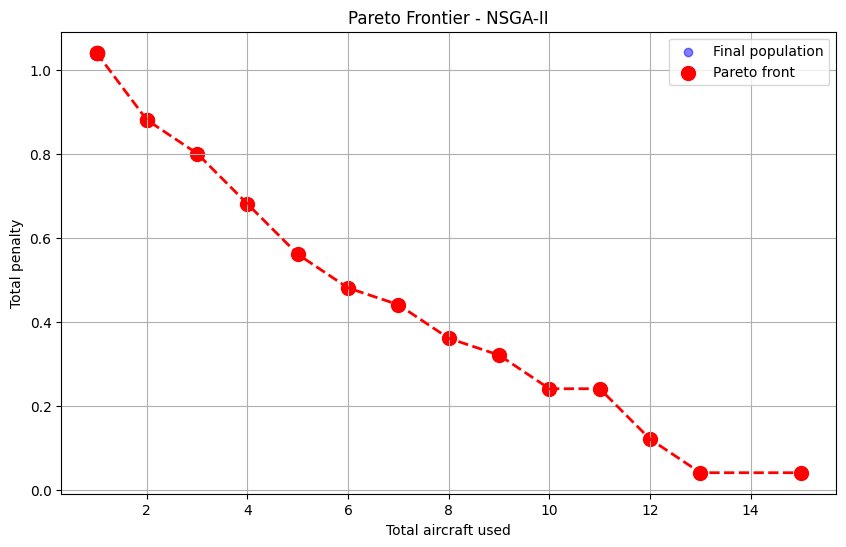

In [11]:
# Sort flights by departure time
flights_sorted = sorted(flights, key=lambda x: x["departure"])

# Normalization factor for penalty
norm_factor = 8333333333333.6836

class Individual:
    def __init__(self, chromosome=None):
        self.chromosome = [-1] * len(flights_sorted) if chromosome is None else chromosome
        self.fitness = None
        self.rank = None
        self.crowding_distance = None

    def __lt__(self, other):
        if self.rank is None or other.rank is None:
            if self.fitness is None or other.fitness is None:
                return False
            return sum(self.fitness) < sum(other.fitness)

        if self.rank == other.rank:
            if self.crowding_distance is None or other.crowding_distance is None:
                return False
            return self.crowding_distance > other.crowding_distance
        return self.rank < other.rank

    def __eq__(self, other):
        return self.chromosome == other.chromosome

    def copy(self):
        new_ind = Individual(self.chromosome.copy())
        new_ind.fitness = copy.deepcopy(self.fitness) if self.fitness else None
        new_ind.rank = self.rank
        new_ind.crowding_distance = self.crowding_distance
        return new_ind

def create_random_individual():
    ind = Individual()
    aircraft_positions = {ac["id"]: ac["base"] for ac in aircrafts}
    available_time = {ac["id"]: 0 for ac in aircrafts}

    for i, flight in enumerate(flights_sorted):
        valid_aircrafts = []

        for ac in aircrafts:
            if (aircraft_positions[ac["id"]] == flight["origin"] and
                available_time[ac["id"]] <= flight["departure"]):
                valid_aircrafts.append(ac["id"])

        if valid_aircrafts and random.random() < 0.95:
            ac_id = random.choice(valid_aircrafts)
            ind.chromosome[i] = ac_id
            aircraft_positions[ac_id] = flight["destination"]
            available_time[ac_id] = flight["arrival"]

    if all(x == -1 for x in ind.chromosome):
        flight_idx = random.randint(0, len(flights_sorted) - 1)
        flight = flights_sorted[flight_idx]
        ac_at_origin = [a["id"] for a in aircrafts if a["base"] == flight["origin"]]
        if ac_at_origin:
            ind.chromosome[flight_idx] = random.choice(ac_at_origin)

    return ind

def evaluate_type_penalty(individual):
    penalty = 0
    for i, flight in enumerate(flights_sorted):
        ac_id = individual.chromosome[i]
        if ac_id != -1:
            ac_type = next(a["type"] for a in aircrafts if a["id"] == ac_id)
            if ac_type < flight["min_type"]:
                penalty += 1000 * (flight["min_type"] - ac_type)
    return penalty

def evaluate_delay_risk(individual):
    total_risk = 0
    for i, flight in enumerate(flights_sorted):
        ac_id = individual.chromosome[i]
        if ac_id != -1:
            ac_type = next(a["type"] for a in aircrafts if a["id"] == ac_id)
            origin, dest = flight["origin"], flight["destination"]
            effective_type = min(ac_type, max(delay_prob[(origin, dest)].keys()))
            total_risk += delay_prob[(origin, dest)][effective_type]
    return total_risk

def evaluate_used_aircraft(individual):
    return len(set([ac_id for ac_id in individual.chromosome if ac_id != -1]))

def evaluate_feasibility(individual):
    penalty = 0
    ac_positions = {ac["id"]: ac["base"] for ac in aircrafts}
    ac_available = {ac["id"]: 0 for ac in aircrafts}

    for i, flight in enumerate(flights_sorted):
        ac_id = individual.chromosome[i]
        if ac_id != -1:
            if ac_positions[ac_id] != flight["origin"]:
                penalty += 10000

            if ac_available[ac_id] > flight["departure"]:
                penalty += 10000

            ac_positions[ac_id] = flight["destination"]
            ac_available[ac_id] = flight["arrival"]

    return penalty

def evaluate_individual(individual):
    if all(ac_id == -1 for ac_id in individual.chromosome):
        return [float('inf'), float('inf')]

    type_penalty = evaluate_type_penalty(individual)
    feasibility_penalty = evaluate_feasibility(individual)
    delay_risk = evaluate_delay_risk(individual)
    used_aircraft = evaluate_used_aircraft(individual)

    assigned_flights = sum(1 for gene in individual.chromosome if gene != -1)
    assignment_ratio = assigned_flights / len(individual.chromosome)
    unassigned_penalty = (1 - assignment_ratio) * 1000

    total_penalty = (delay_risk + type_penalty + feasibility_penalty + 10000000000*unassigned_penalty)/norm_factor

    return [total_penalty, used_aircraft]

def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1.chromosome) - 1)
    child1 = Individual(parent1.chromosome[:crossover_point] + parent2.chromosome[crossover_point:])
    child2 = Individual(parent2.chromosome[:crossover_point] + parent1.chromosome[crossover_point:])
    return child1, child2

def mutate(individual, mutation_rate=0.1):
    new_ind = individual.copy()

    for i in range(len(new_ind.chromosome)):
        if random.random() < mutation_rate:
            if random.random() < 0.2:
                new_ind.chromosome[i] = -1
            else:
                new_ind.chromosome[i] = random.choice([a["id"] for a in aircrafts])

    if all(x == -1 for x in new_ind.chromosome):
        flight_idx = random.randint(0, len(flights_sorted) - 1)
        flight = flights_sorted[flight_idx]
        ac_at_origin = [a["id"] for a in aircrafts if a["base"] == flight["origin"]]
        if ac_at_origin:
            new_ind.chromosome[flight_idx] = random.choice(ac_at_origin)

    return new_ind

def repair(individual):
    ac_positions = {ac["id"]: ac["base"] for ac in aircrafts}
    ac_available = {ac["id"]: 0 for ac in aircrafts}
    new_chromosome = individual.chromosome.copy()

    for i, flight in enumerate(flights_sorted):
        ac_id = new_chromosome[i]
        if ac_id != -1:
            if (ac_positions[ac_id] != flight["origin"] or
                ac_available[ac_id] > flight["departure"]):
                new_chromosome[i] = -1
            else:
                ac_positions[ac_id] = flight["destination"]
                ac_available[ac_id] = flight["arrival"]

    return Individual(new_chromosome)

def fast_non_dominated_sort(population):
    S = defaultdict(list)
    n = defaultdict(int)
    rank = defaultdict(int)
    front = [[]]

    for p in range(len(population)):
        population[p].rank = None
        population[p].crowding_distance = None

        for q in range(len(population)):
            if p != q:
                if (population[p].fitness[0] <= population[q].fitness[0] and
                    population[p].fitness[1] <= population[q].fitness[1] and
                    (population[p].fitness[0] < population[q].fitness[0] or
                     population[p].fitness[1] < population[q].fitness[1])):
                    S[p].append(q)
                elif (population[q].fitness[0] <= population[p].fitness[0] and
                      population[q].fitness[1] <= population[p].fitness[1] and
                      (population[q].fitness[0] < population[p].fitness[0] or
                       population[q].fitness[1] < population[p].fitness[1])):
                    n[p] += 1

        if n[p] == 0:
            rank[p] = 0
            front[0].append(p)

    i = 0
    while i < len(front) and front[i]:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    Q.append(q)
        i += 1
        if Q:
            front.append(Q)

    front = [f for f in front if f]

    for i, f in enumerate(front):
        for j in f:
            population[j].rank = i

    return front

def calculate_crowding_distance(population, front):
    if len(front) <= 1:
        if len(front) == 1:
            population[front[0]].crowding_distance = float('inf')
        return

    for i in front:
        population[i].crowding_distance = 0

    for obj in range(2):
        front_sorted = sorted(front, key=lambda i: population[i].fitness[obj])

        population[front_sorted[0]].crowding_distance = float('inf')
        population[front_sorted[-1]].crowding_distance = float('inf')

        for i in range(1, len(front_sorted) - 1):
            obj_range = population[front_sorted[-1]].fitness[obj] - population[front_sorted[0]].fitness[obj]
            if obj_range == 0:
                continue

            if population[front_sorted[i]].crowding_distance == float('inf'):
                continue

            population[front_sorted[i]].crowding_distance += (
                (population[front_sorted[i+1]].fitness[obj] -
                 population[front_sorted[i-1]].fitness[obj]) / obj_range
            )

def tournament_selection(population, k=2):
    selected = []
    for _ in range(len(population)):
        competitors = random.sample(population, k)
        winner = min(competitors)
        selected.append(winner)
    return selected

def nsga2(pop_size=100, generations=100):
    population = [create_random_individual() for _ in range(pop_size)]

    for ind in population:
        ind.fitness = evaluate_individual(ind)

    fronts = fast_non_dominated_sort(population)

    for front in fronts:
        calculate_crowding_distance(population, front)

    best_solutions = []

    for gen in range(generations):
        print(f"Generation {gen+1}/{generations}")

        offspring = []
        selected = tournament_selection(population)

        for i in range(0, len(selected), 2):
            if i+1 < len(selected):
                child1, child2 = crossover(selected[i], selected[i+1])
                child1 = mutate(child1)
                child2 = mutate(child2)
                child1 = repair(child1)
                child2 = repair(child2)
                offspring.extend([child1, child2])

        for ind in offspring:
            ind.fitness = evaluate_individual(ind)

        combined_pop = population + offspring
        fronts = fast_non_dominated_sort(combined_pop)

        for front in fronts:
            calculate_crowding_distance(combined_pop, front)

        new_pop = []
        i = 0
        while i < len(fronts) and len(new_pop) + len(fronts[i]) <= pop_size:
            for idx in fronts[i]:
                new_pop.append(combined_pop[idx])
            i += 1

        if len(new_pop) < pop_size and i < len(fronts):
            last_front = [combined_pop[idx] for idx in fronts[i]]
            last_front.sort(key=lambda ind: -ind.crowding_distance if ind.crowding_distance is not None else float('-inf'))
            new_pop.extend(last_front[:pop_size - len(new_pop)])

        if fronts and fronts[0]:
            front1_solutions = [combined_pop[idx] for idx in fronts[0]]
            valid_solutions = [ind for ind in front1_solutions
                             if any(ac_id != -1 for ac_id in ind.chromosome)]
            if valid_solutions:
                best_solutions.extend(valid_solutions)

        population = new_pop

    if best_solutions:
        all_solutions = population + best_solutions
        final_fronts = fast_non_dominated_sort(all_solutions)
        pareto_front = [all_solutions[idx] for idx in final_fronts[0]]

        unique_pareto = []
        seen_chromosomes = set()
        for ind in pareto_front:
            chrom_tuple = tuple(ind.chromosome)
            if chrom_tuple not in seen_chromosomes:
                seen_chromosomes.add(chrom_tuple)
                unique_pareto.append(ind)

        return unique_pareto, population
    else:
        fronts = fast_non_dominated_sort(population)
        if fronts:
            pareto_front = [population[idx] for idx in fronts[0]]
            return pareto_front, population
        else:
            return [], population

def plot_results(pareto_front, final_population):
    x_pareto = [ind.fitness[1] for ind in pareto_front]
    y_pareto = [ind.fitness[0] for ind in pareto_front]

    x_pop = [ind.fitness[1] for ind in final_population]
    y_pop = [ind.fitness[0] for ind in final_population]

    plt.figure(figsize=(10, 6))
    plt.scatter(x_pop, y_pop, color='blue', alpha=0.5, label='Final population')
    plt.scatter(x_pareto, y_pareto, color='red', s=100, marker='o', label='Pareto front')

    if x_pareto:
        pareto_sorted = sorted(zip(x_pareto, y_pareto))
        x_pareto_sorted = [x for x, y in pareto_sorted]
        y_pareto_sorted = [y for x, y in pareto_sorted]
        plt.plot(x_pareto_sorted, y_pareto_sorted, 'r--', linewidth=2)

    plt.xlabel('Total aircraft used')
    plt.ylabel('Total penalty')
    plt.title('Pareto Frontier - NSGA-II')
    plt.grid(True)
    plt.legend()

    print("\nSolutions in Pareto front:")
    for i, ind in enumerate(pareto_front):
        print(f"Solution {i+1}: Aircraft used = {ind.fitness[1]}, Penalty = {ind.fitness[0]:.4f}")

        used_aircraft = set([ac_id for ac_id in ind.chromosome if ac_id != -1])
        print(f"  Aircraft used: {sorted(used_aircraft)}, total: {len(used_aircraft)}")

        unassigned = [i for i, ac_id in enumerate(ind.chromosome) if ac_id == -1]
        print(f"  Unassigned flights: {len(unassigned)} of {len(flights_sorted)}")

    plt.show()

# Run the algorithm
pareto_front, final_population = nsga2(pop_size=120, generations=100)
plot_results(pareto_front, final_population)